In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
device = 'cuda:0'

In [5]:
import numpy as np
import torch
from torchvision import transforms, datasets
from torchvision.utils import save_image

import unsplit.attacks as unsplit
from unsplit.models import *
from unsplit.util import *

from tqdm import tqdm

Change the dataset and split layer values as desired. Dataset can be one of `mnist`, `f_mnist`, while the split depth is between 1 and 6 both for CNN and MLP.

In [6]:
dataset_name = "mnist"
architecture = "mlp"
device = "cuda"
batch_size = 64

n_epochs = 10
split_layer = 1

In [7]:
def create_models_and_data(dataset_name="mnist", architecture="mlp", batch_size=64, device="cuda:0", seed=0):
    assert dataset_name in ["mnist", "f_mnist"], "Wrong dataset name. Valid options are 'mnist' and 'f_mnist'."
    assert architecture in ["mlp", "cnn"], "Wrong architecture name. Valid options are 'mlp' and 'cnn'."
    dataset_creator = datasets.MNIST if dataset_name == "mnist" else datasets.FashionMNIST
    model_creator = MLP if architecture == "mlp" else CNN

    trainset = dataset_creator(f'data/{dataset_name}', download=True, train=True, transform=transforms.ToTensor())
    testset = dataset_creator(f'data/{dataset_name}', download=True, train=False, transform=transforms.ToTensor())

    torch.manual_seed(seed)
    client, server = model_creator().to(device), model_creator().to(device)
    return client, server, trainset, testset

In [ ]:
client, server, trainset, testset = create_models_and_data(dataset_name=dataset_name,
                                                           architecture=architecture,
                                                           batch_size=batch_size,
                                                           device=device)

## Without Noise

The next part trains the client and server models. You can skip this step and launch the attack directly as well.

In [8]:
def train_client_server(client, server, trainset, testset, split_layer, n_epochs=10, device="cuda:0", batch_size=64):
    trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
    testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=64)

    client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
    server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        running_loss = 0
        for images, labels in tqdm(trainloader):
            images, labels = images.to(device), labels.to(device)
            client_opt.zero_grad()
            server_opt.zero_grad()

            client_pred = client(images, end=split_layer)
            pred = server(client_pred, start=split_layer+1)

            loss = criterion(pred, labels)
            loss.backward()
            running_loss += loss

            server_opt.step()
            client_opt.step()
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_acc(client, server, testloader, split=split_layer)}')
    return client, server

In [ ]:
client, server = train_client_server(client=client, server=server, trainset=trainset, testset=testset,
                                     split_layer=split_layer, n_epochs=10, device=device)

We are now ready to launch the attack. The next code cell loads `COUNT` many examples from each class of the dataset. Those examples will be used as targets in the attack.

In [ ]:
COUNT = 1
inversion_targets = [get_examples_by_class(testset, i, count=COUNT).to(device) for i in range(10)]

In [ ]:
display_imagelist(inversion_targets)

In [ ]:
main_iters, input_iters, model_iters = 200, 20, 20
lambda_l2, lambda_tv = 0.1, 1.0

In [9]:
def launch_attack(inversion_targets, client, split_layer, clone_architecture="mlp",
                  main_iters=1000, input_iters=100, model_iters=100,
                  lambda_tv=0.1, lambda_l2=1, device="cuda:0"):
    assert clone_architecture in ["mlp", "cnn"], "Wrong architecture name. Valid options are 'mlp' and 'cnn'."
    clone = MLP() if architecture == "mlp" else CNN()
    mse = torch.nn.MSELoss()

    reconstructed_images, reconstruction_losses = [], []
    cut_layer_training_losses = []
    for idx, target in enumerate(inversion_targets):
        # obtain client output
        with torch.no_grad():
            client_out = client(target, end=split_layer)

        # perform the attack
        target_size = target.size()
        reconstructed, cur_loss_arr = unsplit.model_inversion_stealing(
            clone, split_layer, client_out, target_size,
            main_iters=main_iters, input_iters=input_iters, model_iters=model_iters,
            lambda_tv=lambda_tv, lambda_l2=lambda_l2, device=device
        )
        cut_layer_training_losses.append(cur_loss_arr)

        # save result
        reconstructed = normalize(reconstructed)
        reconstructed_images.append(reconstructed)
        reconstruction_loss = mse(reconstructed, target)
        reconstruction_losses.append(reconstruction_loss.item())
    return clone, reconstructed_images, reconstruction_losses, cut_layer_training_losses

In [ ]:
clone, reconstructed_images, reconstruction_losses, cut_layer_training_losses = launch_attack(
    inversion_targets, client, split_layer, clone_architecture=architecture,
    main_iters=main_iters, input_iters=input_iters, model_iters=model_iters,
    lambda_tv=lambda_tv, lambda_l2=lambda_l2, device=device
)

In [ ]:
display_imagelist(inversion_targets)
display_imagelist(reconstructed_images)

In [10]:
def compute_metrics(inversion_targets, reconstructed_images,
                    reconstruction_losses, cut_layer_training_losses,
                    compute_fid=False):
    reconstruction_mse = np.mean(reconstruction_losses)
    cut_layer_mse = np.mean([loss_arr[-1] for loss_arr in cut_layer_training_losses])
    print(f"Recounstruction MSE: {reconstruction_mse:.3f}")
    print(f"Log10 of cut layer MSE: {np.log10(cut_layer_mse):.3f}")
    if compute_fid:
        print(f"FID: {compute_fid(inversion_targets, reconstructed_images):.1f}")

In [ ]:
compute_metrics(inversion_targets, reconstructed_images, reconstruction_losses, cut_layer_training_losses)

## With Noise

Initialize models and data again

In [11]:
client, server, trainset, testset = create_models_and_data(dataset_name=dataset_name,
                                                           architecture=architecture,
                                                           batch_size=batch_size,
                                                           device=device)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16043329.66it/s]


Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 475386.83it/s]


Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4305004.92it/s]


Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2770583.01it/s]


Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



Find global $l2$-sensitivity

In [12]:
import random

def find_l2_sensitivity(trainloader):
    total_batches = 0
    summed_batch = None
    for batch in trainloader:
        if summed_batch is None:
            summed_batch = torch.zeros_like(batch[0])
        if batch[0].size(0) == summed_batch.size(0):
            summed_batch += batch[0]
            total_batches += 1

    averaged_batch = summed_batch / total_batches

    averaged_batch_copy = averaged_batch.clone()
    s = random.randint(0, 64)
    averaged_batch_copy[s] = torch.zeros_like(averaged_batch_copy[s])
    gs = torch.norm(averaged_batch - averaged_batch_copy, p='fro').float()
    return gs

Now let us adjust distribution parameter $\sigma$ for $(\varepsilon, \delta)$-DP.

Code is taken from https://github.com/BorjaBalle/analytic-gaussian-mechanism/blob/master/agm-example.py

In [13]:
from math import exp, sqrt
from scipy.special import erf

def calibrateAnalyticGaussianMechanism(epsilon, delta, GS, tol = 1.e-12):
    """ Calibrate a Gaussian perturbation for differential privacy using the analytic Gaussian mechanism of [Balle and Wang, ICML'18]

    Arguments:
    epsilon : target epsilon (epsilon > 0)
    delta : target delta (0 < delta < 1)
    GS : upper bound on L2 global sensitivity (GS >= 0)
    tol : error tolerance for binary search (tol > 0)

    Output:
    sigma : standard deviation of Gaussian noise needed to achieve (epsilon,delta)-DP under global sensitivity GS
    """

    def Phi(t):
        return 0.5*(1.0 + erf(float(t)/sqrt(2.0)))

    def caseA(epsilon,s):
        return Phi(sqrt(epsilon*s)) - exp(epsilon)*Phi(-sqrt(epsilon*(s+2.0)))

    def caseB(epsilon,s):
        return Phi(-sqrt(epsilon*s)) - exp(epsilon)*Phi(-sqrt(epsilon*(s+2.0)))

    def doubling_trick(predicate_stop, s_inf, s_sup):
        while(not predicate_stop(s_sup)):
            s_inf = s_sup
            s_sup = 2.0*s_inf
        return s_inf, s_sup

    def binary_search(predicate_stop, predicate_left, s_inf, s_sup):
        s_mid = s_inf + (s_sup-s_inf)/2.0
        while(not predicate_stop(s_mid)):
            if (predicate_left(s_mid)):
                s_sup = s_mid
            else:
                s_inf = s_mid
            s_mid = s_inf + (s_sup-s_inf)/2.0
        return s_mid

    delta_thr = caseA(epsilon, 0.0)

    if (delta == delta_thr):
        alpha = 1.0

    else:
        if (delta > delta_thr):
            predicate_stop_DT = lambda s : caseA(epsilon, s) >= delta
            function_s_to_delta = lambda s : caseA(epsilon, s)
            predicate_left_BS = lambda s : function_s_to_delta(s) > delta
            function_s_to_alpha = lambda s : sqrt(1.0 + s/2.0) - sqrt(s/2.0)

        else:
            predicate_stop_DT = lambda s : caseB(epsilon, s) <= delta
            function_s_to_delta = lambda s : caseB(epsilon, s)
            predicate_left_BS = lambda s : function_s_to_delta(s) < delta
            function_s_to_alpha = lambda s : sqrt(1.0 + s/2.0) + sqrt(s/2.0)

        predicate_stop_BS = lambda s : abs(function_s_to_delta(s) - delta) <= tol

        s_inf, s_sup = doubling_trick(predicate_stop_DT, 0.0, 1.0)
        s_final = binary_search(predicate_stop_BS, predicate_left_BS, s_inf, s_sup)
        alpha = function_s_to_alpha(s_final)

    sigma = alpha*GS/sqrt(2.0*epsilon)

    return sigma

In [14]:
import torch.distributions as dist

class CustomNormalDistribution(torch.nn.Module):
    def __init__(self, shape, mean, std):
        super(CustomNormalDistribution, self).__init__()
        self.shape = shape
        self.mean = torch.nn.Parameter(torch.tensor(mean))
        self.std = torch.nn.Parameter(torch.tensor(std))

    def forward(self):
        return dist.Normal(self.mean, self.std)


def noisybatch(images, mean=0.0, std=1.0):
    shape = images.shape
    custom_dist = CustomNormalDistribution(shape, mean, std)
    sample = custom_dist().rsample()
    return sample

In [15]:
def train_client_server_noise(client, server, trainset, testset, split_layer, epsilon, delta, n_epochs=10, device="cuda:0", batch_size=64):
    trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
    testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=64)

    client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
    server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
    criterion = torch.nn.CrossEntropyLoss()

    gs = find_l2_sensitivity(trainloader)
    print(r"The global $\ell_2$ sensitivity is:", gs)
    sigma = calibrateAnalyticGaussianMechanism(epsilon=epsilon, delta=delta, GS=gs)
    print(r"The $\sigma$ for noise is:", sigma)


    for epoch in range(n_epochs):
        running_loss = 0
        for images, labels in tqdm(trainloader):
            images, labels = images.to(device), labels.to(device)
            client_opt.zero_grad()
            server_opt.zero_grad()

            noise = noisybatch(images, mean=0.0, std=sigma)
            client_pred = client(torch.add(images, noise), end=split_layer)
            pred = server(client_pred, start=split_layer+1)

            loss = criterion(pred, labels)
            loss.backward()
            running_loss += loss

            server_opt.step()
            client_opt.step()
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_acc(client, server, testloader, split=split_layer)}')
    return client, server, sigma

You may adjust your changes into ` epsilon`  and ` delta` .
Also, do not hesitate to increase the number of epochs, since the noise may slow down the training process.

In [16]:
client, server, sigma = train_client_server_noise(client=client, server=server, trainset=trainset, testset=testset,
                                     split_layer=split_layer, epsilon=6, delta=0.5,  n_epochs=10, device=device)

The global $\ell_2$ sensitivity is: tensor(5.9427)
The $\sigma$ for noise is: tensor(1.5905)


  0%|          | 0/938 [00:00<?, ?it/s]<ipython-input-14-f805027c5019>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.nn.Parameter(torch.tensor(std))
100%|██████████| 938/938 [00:10<00:00, 87.91it/s] 


Epoch: 0 Loss: 2.2732670307159424 Acc: 0.7443000078201294


100%|██████████| 938/938 [00:09<00:00, 95.57it/s]


Epoch: 1 Loss: 2.171572685241699 Acc: 0.758899986743927


100%|██████████| 938/938 [00:09<00:00, 99.29it/s]


Epoch: 2 Loss: 2.028795003890991 Acc: 0.8172000050544739


100%|██████████| 938/938 [00:09<00:00, 103.71it/s]


Epoch: 3 Loss: 1.7393639087677002 Acc: 0.8165000081062317


100%|██████████| 938/938 [00:09<00:00, 97.28it/s] 


Epoch: 4 Loss: 1.5229802131652832 Acc: 0.8672999739646912


100%|██████████| 938/938 [00:10<00:00, 86.49it/s]


Epoch: 5 Loss: 1.0489062070846558 Acc: 0.8745999932289124


100%|██████████| 938/938 [00:09<00:00, 93.84it/s]


Epoch: 6 Loss: 0.7239120006561279 Acc: 0.8913999795913696


100%|██████████| 938/938 [00:10<00:00, 85.94it/s] 


Epoch: 7 Loss: 0.5496866703033447 Acc: 0.905299961566925


100%|██████████| 938/938 [00:09<00:00, 95.04it/s] 


Epoch: 8 Loss: 0.3931313157081604 Acc: 0.920799970626831


100%|██████████| 938/938 [00:09<00:00, 95.39it/s] 


Epoch: 9 Loss: 0.4614049196243286 Acc: 0.9065999984741211


Now let us see how adding noise affects on attacks.

In [24]:
COUNT = 1
inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]

In [ ]:
noised_inversion_targets = inversion_targets
inversion_targets[0].shape
for c in range(10):
    noise = noisybatch(inversion_targets[c], mean=0.0, std=sigma)
    noised_inversion_targets[c] = torch.add(inversion_targets[c], noise).to(device)

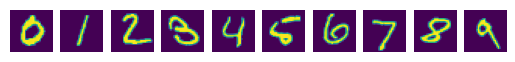

In [26]:
display_imagelist(noised_inversion_targets)

In [27]:
main_iters, input_iters, model_iters = 200, 20, 20
lambda_l2, lambda_tv = 0.1, 1.0

In [28]:
clone, reconstructed_images, reconstruction_losses, cut_layer_training_losses = launch_attack(
    noised_inversion_targets, client, split_layer, clone_architecture=architecture,
    main_iters=main_iters, input_iters=input_iters, model_iters=model_iters,
    lambda_tv=lambda_tv, lambda_l2=lambda_l2, device=device
)

100%|██████████| 200/200 [00:15<00:00, 12.95it/s]


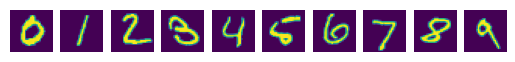

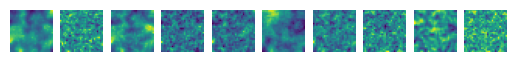

In [29]:
display_imagelist(noised_inversion_targets)
display_imagelist(reconstructed_images)

In [30]:
compute_metrics(noised_inversion_targets, reconstructed_images, reconstruction_losses, cut_layer_training_losses)

Recounstruction MSE: 5.383
Log10 of cut layer MSE: -6.348


In [31]:
compute_metrics(noised_inversion_targets, reconstructed_images, reconstruction_losses, cut_layer_training_losses)

Recounstruction MSE: 5.383
Log10 of cut layer MSE: -6.348
